In [1]:
%pip install pyzmq==19.0.2
%pip show pyzmq
import scipy.io
import pandas as pd
import numpy as np
from numpy import argmax, sqrt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, PrecisionRecallDisplay, average_precision_score, RocCurveDisplay, precision_recall_curve, roc_curve, ConfusionMatrixDisplay, roc_auc_score, auc

Note: you may need to restart the kernel to use updated packages.
Name: pyzmq
Version: 19.0.2
Summary: Python bindings for 0MQ
Home-page: https://pyzmq.readthedocs.org
Author: Brian E. Granger, Min Ragan-Kelley
Author-email: zeromq-dev@lists.zeromq.org
License: LGPL+BSD
Location: /home/eszter/miniconda3/lib/python3.9/site-packages
Requires: 
Required-by: qtconsole, notebook, nbclassic, jupyter-server, jupyter-console, jupyter_client, ipykernel
Note: you may need to restart the kernel to use updated packages.


## Data Preprocessing and Visualization
Within this section, I initiate by loading the data. Subsequently, I remove stop words using the provided bag of words matrix and then convert the data into TF-IDF representation. Lastly, I examine the ratio of classes within the dataset.

In [2]:
# Get X and Y from email dataset

dataset = scipy.io.loadmat('emails.mat')
X = dataset["X"]
dense = X.todense() # turn this into the bag of word dense matrix
Y = dataset["Y"]

print("The type of Y: ", type(Y))
print("The shape of Y:", Y.shape)
print("The type of X: ", type(dense))
print("The shape of X: ", dense.shape)

The type of Y:  <class 'numpy.ndarray'>
The shape of Y: (1, 10000)
The type of X:  <class 'numpy.matrix'>
The shape of X:  (57173, 10000)


In [3]:
# Replace +1 (spam) and -1 (nonspam) labels into {1, 0] 
Y = np.array(Y).reshape(-1)
Y[Y == -1] = 0

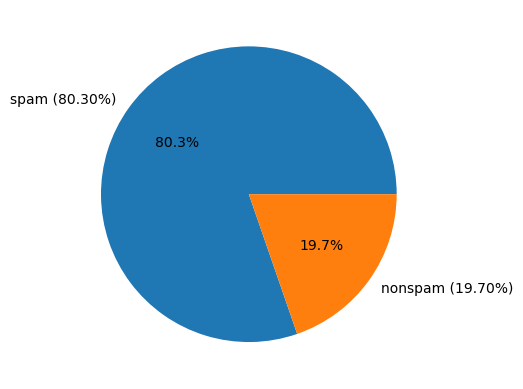

Number of spams in total: 8030
Number of nonspams in total: 1970


In [4]:
# Count the numbers of 0 and 1 in Y
spam_in_y = np.count_nonzero(Y == 1)
nonspam_in_y = np.count_nonzero(Y == 0)

# Calculate the percentages
total_samples = len(Y)
spam_percentage = (spam_in_y / total_samples) * 100
nonspam_percentage = (nonspam_in_y / total_samples) * 100

labels = f"spam ({spam_percentage:.2f}%)", f"nonspam ({nonspam_percentage:.2f}%)"
nums = [spam_in_y, nonspam_in_y]
fig, ax = plt.subplots()
ax.pie(nums, labels=labels, autopct='%1.1f%%')
plt.show()

print("Number of spams in total:", spam_in_y)
print("Number of nonspams in total:", nonspam_in_y)

In [5]:
# Remove 100 stop words based on the frequency of word (remove top 100 words that occur the most)
term_frequencies = dense.sum(axis=1)

# Sort terms by term frequency in descending order
sorted_indices = np.argsort(term_frequencies, axis=0)[::-1]

num_high_frequency_terms = 100
# Identify potential stop words based on high-frequency terms
potential_stop_words_indices = sorted_indices[:num_high_frequency_terms]

# Remove potential stop words from the matrix
filtered_bag_of_words_matrix = np.delete(dense, potential_stop_words_indices, axis=0)


print(filtered_bag_of_words_matrix.shape)

(57073, 10000)


In [6]:
# Split the data into 8:2 ratio (train:test)
bow_X_train, bow_X_test, Y_train, Y_test = train_test_split(filtered_bag_of_words_matrix.T, Y.T, test_size=0.2, random_state=42)

# Transpose the label back to its original shape
Y_train = Y_train.T
Y_test = Y_test.T

# And convert X into np array for later
bow_X_train = np.array(bow_X_train)
bow_X_test = np.array(bow_X_test)

# Print the shapes of the train and test sets
# X = (num of samples, num of features)
# Y = (num of samples, )
print("bow_X_train shape:", bow_X_train.shape)
print("bow_X_test shape:", bow_X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

bow_X_train shape: (8000, 57073)
bow_X_test shape: (2000, 57073)
Y_train shape: (8000,)
Y_test shape: (2000,)


In [7]:
# Transform Bag of Words matrix into TF-IDF Representation
# Because Tf-idf gives extra importance to uncommon words and doesn't pay much attention to common words.
# Remember the count matrix fed to the TFIDF Transformer needs to be a matrix of shape (num of samples, num of words)

tfidf_transformer = TfidfTransformer()
tfidf_X_train = tfidf_transformer.fit_transform(bow_X_train)
tfidf_X_test = tfidf_transformer.transform(bow_X_test)

In [8]:
spam_in_train = np.count_nonzero(Y_train == 1)
spam_in_test = np.count_nonzero(Y_test == 1)
nonspam_in_train = np.count_nonzero(Y_train == 0)
nonspam_in_test = np.count_nonzero(Y_test == 0)

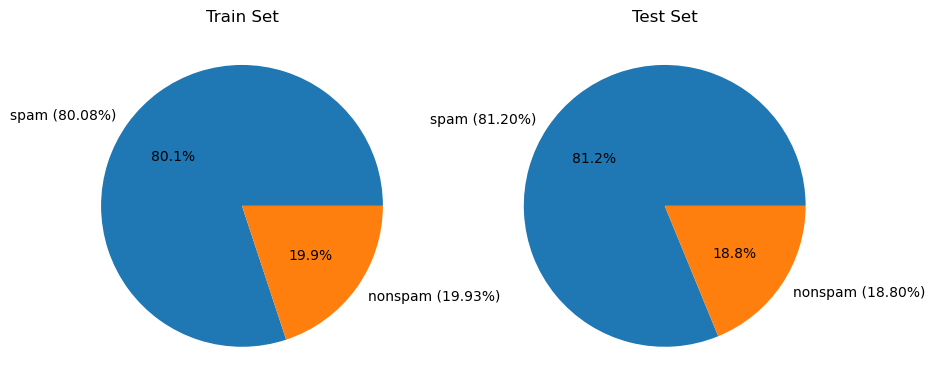

In [9]:
def create_pie_subplot(ax, spam_count, nonspam_count, title):
    total_samples = spam_count + nonspam_count
    spam_percentage = (spam_count / total_samples) * 100
    nonspam_percentage = (nonspam_count / total_samples) * 100
    labels = f"spam ({spam_percentage:.2f}%)", f"nonspam ({nonspam_percentage:.2f}%)"
    nums = [spam_count, nonspam_count]
    ax.pie(nums, labels=labels, autopct='%1.1f%%')
    ax.set_title(title)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot pie chart for the train set
create_pie_subplot(ax1, spam_in_train, nonspam_in_train, "Train Set")

# Plot pie chart for the test set
create_pie_subplot(ax2, spam_in_test, nonspam_in_test, "Test Set")

plt.show()

Once the data is prepared, it is divided into an 80:20 ratio, allocating 80% for the training set and 20% for the test set. Also, the label 1 is spam, label 0 is non-spam. The class ratio before dividing is plotted, and it becomes evident that there is an imbalance in the data, as the majority class is composed of spam emails.

## Model Training and Evaluation
The goal is **"no more than 0.2% of all legitimate emails is filtered."** Namely, among all the non-spam emails (true label = 0), no more than 0.2%, are incorrectly classified as spam by the filtering system. In confusion matrix, FP/(FP+TN), which is also **False Positive Rate**, less than 0.002.
|                      | Actual Positive (Spam) | Actual Negative (Non-Spam) |
|----------------------|------------------------|------------------------------|
| Predicted Positive   | True Positive (TP)     | False Positive (FP)          |
| Predicted Negative   | False Negative (FN)    | True Negative (TN)     

The expected quality of the Logistic Regression Spam Classifier with Bag of Words (BoW) representation and TF-IDF depends on the specific characteristics of the dataset and the nature of the spam classification task. Here are statements about the expected quality of each representation:

**Logistic Regression Spam Classifier with BoW Representation**:

- **Strengths**: BoW representation is effective at capturing the frequency of words in documents, making it suitable for capturing simple keyword-based patterns often associated with spam messages. It is memory-efficient and can perform well on smaller datasets with limited feature space.

- **Expected Performance**: The BoW-based classifier is likely to perform reasonably well on spam classification tasks where spam messages are characterized by the presence of certain keywords or phrases. However, it may struggle with more nuanced spam messages that rely on context and subtle cues.

**Logistic Regression Spam Classifier with TF-IDF Representation**:

- **Strengths**: TF-IDF representation is better at capturing the importance of words by considering their frequency in the document and across the entire corpus. It can handle more complex relationships between words and is effective at distinguishing relevant terms from common ones.

- **Expected Performance**: The TF-IDF-based classifier is expected to provide better overall performance on a wide range of spam classification tasks. It is particularly suited for tasks where spam messages may employ variations in keywords and rely on contextual information. TF-IDF can help the classifier identify and weigh important terms em classifier.


In [10]:
lr_tfidf = LogisticRegression(solver = "sag")
lr_tfidf.fit(tfidf_X_train, Y_train)


LogisticRegression(solver='sag')

In [11]:
lr_bow = LogisticRegression(solver = "sag")
lr_bow.fit(bow_X_train, Y_train)

/home/eszter/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(solver='sag')

In [12]:
tfidf_y_pred = lr_tfidf.predict(tfidf_X_test)
bow_y_pred = lr_bow.predict(bow_X_test)

In [13]:
tfidf_tn, tfidf_fp, tfidf_fn, tfidf_tp = confusion_matrix(Y_test, tfidf_y_pred).ravel()
tfidf_fp_rate = tfidf_fp / (tfidf_tn+tfidf_fp)

bow_tn, bow_fp, bow_fn, bow_tp = confusion_matrix(Y_test, bow_y_pred).ravel()
bow_fp_rate = bow_fp / (bow_tn+bow_fp)

print("False Positive Rate Before Thresholding")
print("Logistic Regression with TF-IDF ", tfidf_fp_rate)
print("Logistic Regression with BoW: ", bow_fp_rate)

False Positive Rate Before Thresholding
Logistic Regression with TF-IDF  0.015957446808510637
Logistic Regression with BoW:  0.03723404255319149


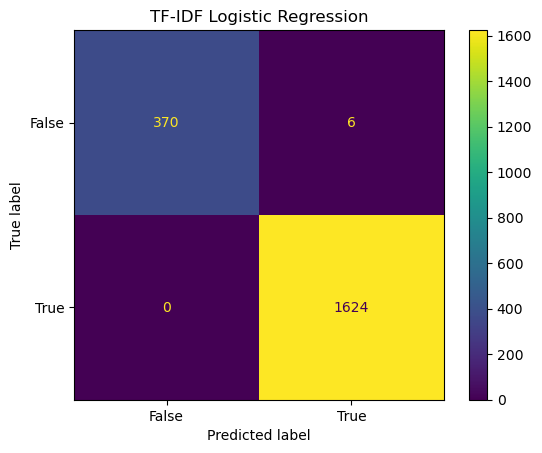

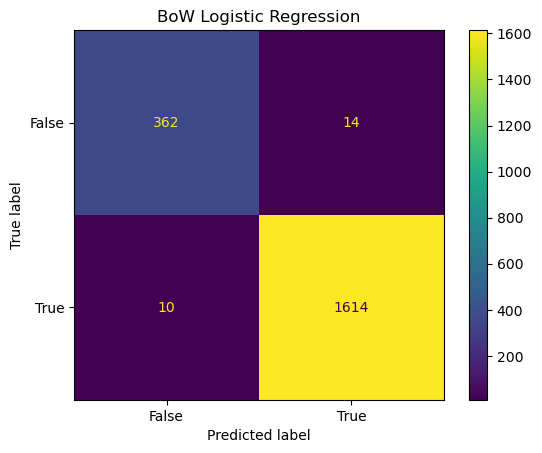

In [14]:
def disp_confusion_matrix(actual, predicted, model_name):
    cm = confusion_matrix(actual, predicted)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
    cm_display.plot()
    cm_display.ax_.set_title(model_name)
    plt.show()
    
disp_confusion_matrix(Y_test, tfidf_y_pred, "TF-IDF Logistic Regression")
disp_confusion_matrix(Y_test, bow_y_pred, "BoW Logistic Regression")

In summary, logistic regression with the "sag" solver is particularly well-suited for handling large datasets, especially when dealing with sparse data. This solver demonstrates its effectiveness by achieving a lower False Positive Rate before thresholding compared to logistic regression with Bag of Words (BoW) representation.

- **Logistic Regression with TF-IDF**: Achieves a lower False Positive Rate before thresholding, demonstrating its robustness and efficiency in handling sparse high-dimensional data. The False Positive Rate for TF-IDF is approximately 0.016.

- **Logistic Regression with BoW**: Yields a higher False Positive Rate before thresholding, approximately 0.037. Additionally, it is noteworthy that logistic regression with BoW fails to converge even after increasing the maximum number of iterations, highlighting its limitations in handling the dataset effectively.

Given these observations, it is reasonable to choose logistic regression with TF-IDF representation for subsequent thresholding and classification tasks due to its better performance in terms of False Positive Rate and convergence.

## Thresholding
To effectively reduce the false positive rate, my approach involves plotting the ROC curve, where the true positive rate and false positive rate are the key components. Despite this, **the project guidelines explicitly highlight the need to create a precision/recall curve and identify the model's position on that curve.** Consequently, I will generate both types of graphs. By doing so, I can determine the best thresholds for the Logistic Regression model in each scenario. Ultimately, the objective is to identify the curve that provides a more suitable threshold, aligning with our criterion of **achieving a false positive rate of less than 0.2%.**"

<Figure size 800x600 with 0 Axes>

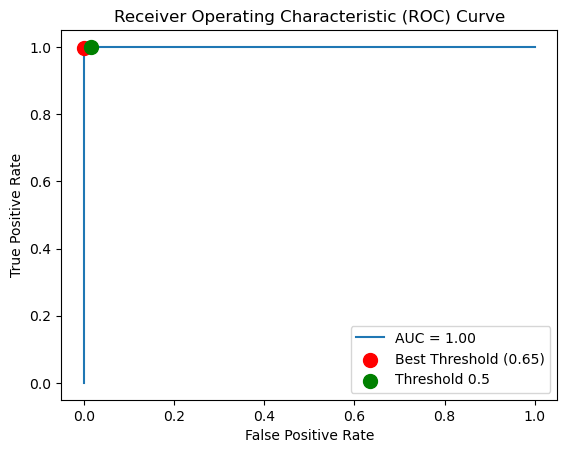

Best Threshold: 0.6514762219703001
False Positive Rate after Thresholding: 0.0


In [15]:
# Predict probabilities
y_prob = lr_tfidf.predict_proba(tfidf_X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_prob)

# Calculate ROC AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display.plot()

# Find the best threshold
best_threshold_index = np.argmax(tpr - fpr)
best_threshold = thresholds[best_threshold_index]

# Apply the best threshold to get binary predictions
y_pred_thresholded = (y_prob > best_threshold).astype(int)

# Calculate the false positive rate after thresholding
fpr_after_thresholding = np.sum((y_pred_thresholded == 1) & (Y_test == 0)) / np.sum(Y_test == 0)

# Plot a red dot at the best threshold
plt.scatter(fpr[best_threshold_index], tpr[best_threshold_index], color='red', label=f'Best Threshold ({best_threshold:.2f})', s=100, zorder=5)

# Plot a green dot at the threshold of 0.5
threshold_0_5_index = np.argmin(np.abs(thresholds - 0.5))
plt.scatter(fpr[threshold_0_5_index], tpr[threshold_0_5_index], color='green', label='Threshold 0.5', s=100, zorder=5)

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

print("Best Threshold:", best_threshold)
print("False Positive Rate after Thresholding:", fpr_after_thresholding)

<Figure size 800x600 with 0 Axes>

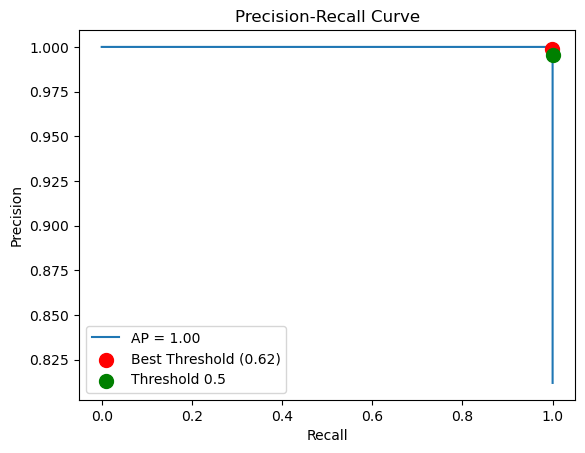

Best Threshold: 0.6155403981289432
False Positive Rate after Thresholding: 0.005319148936170213


In [16]:
# Calculate Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, y_prob)

# Calculate average precision score
average_precision = average_precision_score(Y_test, y_prob)

# Plot PR curve
plt.figure(figsize=(8, 6))
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=average_precision)
pr_display.plot()

# Find the best threshold
fscore = (2 * precision * recall) / (precision + recall)
best_threshold_index = np.argmax(fscore)
best_threshold = thresholds[best_threshold_index]

# Apply the best threshold to get binary predictions
y_pred_thresholded = (y_prob > best_threshold).astype(int)

# Calculate the false positive rate after thresholding
fpr_after_thresholding = np.sum((y_pred_thresholded == 1) & (Y_test == 0)) / np.sum(Y_test == 0)

# Plot a red dot at the best threshold
plt.scatter(recall[best_threshold_index], precision[best_threshold_index], color='red', label=f'Best Threshold ({best_threshold:.2f})', s=100, zorder=5)

# Plot a green dot at the threshold of 0.5
threshold_0_5_index = np.argmin(np.abs(thresholds - 0.5))
plt.scatter(recall[threshold_0_5_index], precision[threshold_0_5_index], color='green', label='Threshold 0.5', s=100, zorder=5)

plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

print("Best Threshold:", best_threshold)
print("False Positive Rate after Thresholding:", fpr_after_thresholding)

## Conclusion

In conclusion, TF-IDF representation outperforms Bag of Words (BoW) because it takes into account the importance of individual terms in a document relative to the entire corpus, capturing more meaningful information. TF-IDF assigns higher weights to terms that are rare in the corpus but frequent in a particular document, making it more effective at distinguishing important terms from common ones. As a result, TF-IDF often leads to better performance in natural language processing tasks.

Regarding threshold selection:

- The **Best Threshold** obtained using the ROC curve is **0.6515**. This threshold is chosen to optimize the trade-off between true positive rate and false positive rate, making it a suitable choice when balancing sensitivity and specificity is crucial. In this case, the **False Positive Rate after Thresholding** using the ROC curve is **0.0**, indicating a successful balance between true and false positives.

- The **Best Threshold** obtained using the PR (Precision-Recall) curve is **0.6155**. PR curves focus on precision and recall, which are particularly useful when dealing with imbalanced datasets or when precision is of greater importance than the true negative rate. Despite a slightly higher threshold, the **False Positive Rate after Thresholding** using the PR curve is still low at **0.0053**, reflecting the effectiveness of this threshold in controlling false positives while maintaining high precision.
